In [1]:
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

40000


In [5]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

40000


In [8]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
    img = cv.imread(path)  # Reads the image into a numpy.array
    img_cvt = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Converts into the correct color space (RGB)
    img_resize = cv.resize(img_cvt, (128,128))
    print(img.shape)
    print(img_cvt.shape)  # Prints the shape of the image just to check
    plt.grid(False)  # Without grid so we can see better

    plt.imshow(img_resize)  # Shows the image
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image"+path)

(240, 640, 3)
(240, 640)


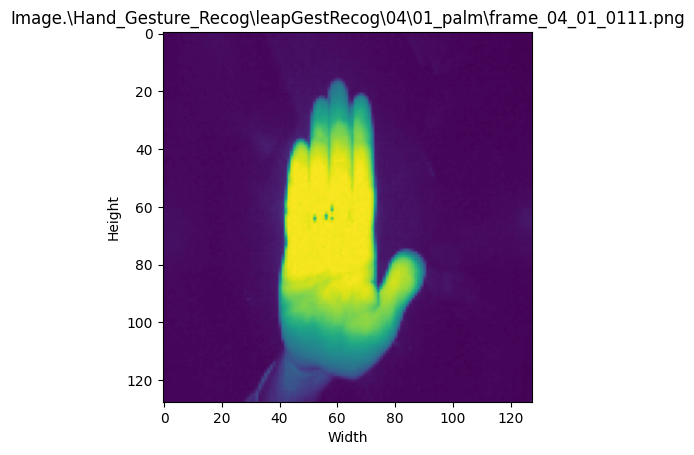

In [9]:
plot_image(imagepaths[8110])

In [10]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv.imread(path) # Reads image and returns np.array
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv.resize(img, (128,128))
  X.append(img)
  
  # Processing label in image path
  category = path.split("\\")[-2]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 128, 128, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  40000
Labels loaded:  40000
1 .\Hand_Gesture_Recog\leapGestRecog\00\01_palm\frame_00_01_0001.png


In [11]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout

In [13]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)      

In [14]:
history=model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1, validation_data=(X_test,y_test))

Epoch 1/5


438/438 [==============================] - 166s 375ms/step - loss: 0.5125 - accuracy: 0.9408 - val_loss: 0.0019 - val_accuracy: 0.9998
Epoch 2/5
438/438 [==============================] - 158s 361ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 4.1653e-04 - val_accuracy: 0.9999
Epoch 3/5
438/438 [==============================] - 166s 379ms/step - loss: 0.0127 - accuracy: 0.9967 - val_loss: 0.0148 - val_accuracy: 0.9948
Epoch 4/5
438/438 [==============================] - 158s 360ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0059 - val_accuracy: 0.9980
Epoch 5/5
438/438 [==============================] - 159s 363ms/step - loss: 3.1838e-04 - accuracy: 0.9999 - val_loss: 2.5701e-05 - val_accuracy: 1.0000


In [15]:
model.save('handrecog_model.h5')

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
model = tf.keras.models.load_model(r"C:\Users\hp\Desktop\hand gesture\Hand_Gesture_Recog\handrecog_model.h5")
tf.saved_model.save(model, "tmp_model")

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


In [17]:
!python -m tf2onnx.convert --saved-model tmp_model --output "handrecognition_model.onnx"

2023-11-22 11:20:55.647186: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2023-11-22 11:21:00.584056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 11:21:00,581 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-11-22 11:21:00,840 - INFO - Signatures found in model: [serving_def